# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game IA) - Sesión 1 - Tarea

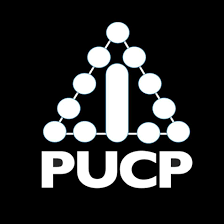
<img src='https://dci.pucp.edu.pe/wp-content/uploads/2014/02/logo-color-pucp1.gif' width=200px>

PhD. Edwin Villanueva, BSc. Daniel Saromo

<font color='orange'>Agente aspirador en una grilla a colores de MxN</font>

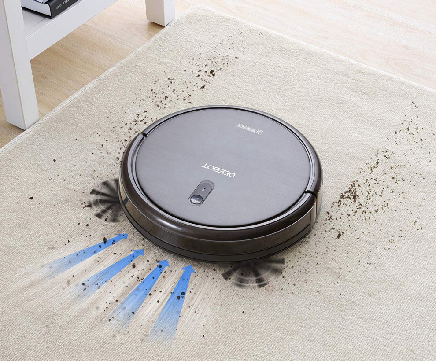

En el presente notebook se tiene la codificación de un agente aspirador (`VacuumAgent`) así como de un entorno gráfico tipo grilla configurable (`room`). Se busca que el agente interactúe con su entorno para limpiarlo.

Completar con su código los campos requeridos y subir su notebook solucionado a la plataforma PAIDEIA. El formato del nombre del notebook es: `Desafio1_APELLIDOPATERNO_NOMBRE.ipynb`.

Es responsabilidad del alumno verificar que el archivo que subió es el correcto. Respetar los lineamientos de la entrega de archivo, ya que influirá en su calificación. La fecha límite de entrega del presente desafío se encuentra en PAIDEIA.

## Clase <b>Thing</b>

  Esta clase generica representa cualquier objeto fisico que puede aparecer en un <b>Ambiente</b>.

In [1]:
class Thing(object):

    def is_alive(self):
        """Cosas 'vivas'deben retornar true."""
        return hasattr(self, 'alive') and self.alive

    def show_state(self):
        """Muestra el estado interno del agente. Subclases deben sobreescribir esto."""
        print("I don't know how to show_state.")

## Clase <b>Agent</b>

Un agente es una subclase de Thing con un slot obligatorio: <b>.program</b>, el cual almacena la funcion que implementa el <b>programa del agente</b>. Esta funcion debe tomar como argumento la <b>percepcion</b> del agente y debe retornar una <b>accion</b>. La definicion de Percepcion y Accion depende del ambiente de trabajo (environment) donde el agente existe. El agente tambien puede tener el slot <b>.performance</b>, que mide el desempeño del agente en su ambiente.

In [2]:
import collections

class Agent(Thing):

    def __init__(self, program=None):
        self.alive = True
        self.performance = 0
        assert isinstance(program, collections.Callable)
        self.program = program

## Clase <b>Environment</b>

Esta clase abstracta representa un entorno de tareas. Clases de entornos reales heredan de esta. En un entorno tipicamente se necesitará implementar 2 cosas:
<b>percept</b>, que define la percepción que el agente ve; y 
<b>execute_action</b>, que define los efectos de ejecutar una acción. 
El entorno mantiene una lista de .things y .agents (el cual es un subconjunto de .things). Cada elemento de .things tiene un slot .location. (No editar)

In [3]:
class Environment(object):

    def __init__(self):
        self.things = []
        self.agents = []

    def thing_classes(self):
        return []  # List of classes that can go into environment

    def percept(self, agent):
        """Retorna la percepcion que el agente 'agent' ve en este punto."""
        raise NotImplementedError

    def execute_action(self, agent, action):
        """El agente 'agent' ejecuta una accion 'action' en el entorno."""
        raise NotImplementedError

    def default_location(self, thing):
        """Localización por defecto para colocar una nueva cosa sin localizacion especificada."""
        return None

    def is_done(self):
        """Retorna True si no hay ningun agente vivo"""
        return not any(agent.is_alive() for agent in self.agents)

    def add_thing(self, thing, location=None):
        """Añade un objeto Thing al entorno en la localizacion location. 
           Si thing es un programa de agente, crea un nuevo agente con ese programa."""
        if not isinstance(thing, Thing):
            thing = Agent(thing)
        assert thing not in self.things, "No añade la misma cosa dos veces"
        thing.location = location if location is not None else self.default_location(thing)
        self.things.append(thing)
        if isinstance(thing, Agent):
            thing.performance = 0
            self.agents.append(thing)
    
    def delete_thing(self, thing):
        """Elimina un objeto Thing al entorno en la localizacion location
        Si thing es un programa de agente, igual lo remueve.
        Remove a thing from the environment."""
        try:
            self.things.remove(thing)
        except ValueError as e:
            print(e)
            print("  in Environment delete_thing")
            print("  Thing to be removed: {} at {}".format(thing, thing.location))
            print("  from list: {}".format([(thing, thing.location) for thing in self.things]))
        if thing in self.agents:
            self.agents.remove(thing)

    def list_things_at(self, location, tclass=Thing):
        """Return all things exactly at a given location."""
        return [thing for thing in self.things
                if thing.location == location and isinstance(thing, tclass)]

    def step(self):
        """Ejecuta un paso del entorno (llama a los programas de los agentes, obtiene sus acciones y las ejecuta). """
        if not self.is_done():
            actions = []
            for agent in self.agents:
                if agent.alive:
                    actions.append(agent.program(self.percept(agent)))
                else:
                    actions.append("")
            for (agent, action) in zip(self.agents, actions):
                self.execute_action(agent, action)

    def run(self, steps=1000):
        """Ejecuta steps pasos en el entorno."""
        for step in range(steps):
            if self.is_done():
                return
            self.step()

## Clase XYEnvironment

In [4]:
class XYEnvironment(Environment):
    """This class is for environments on a 2D plane, with locations
    labelled by (x, y) points, either discrete or continuous.

    Agents perceive things within a radius. Each agent in the
    environment has a .location slot which should be a location such
    as (0, 1), and a .holding slot, which should be a list of things
    that are held."""

    def __init__(self, width=10, height=10):
        super().__init__()

        self.width = width
        self.height = height
        self.observers = []
        # Sets iteration start and end (no walls).
        self.x_start, self.y_start = (0, 0)
        self.x_end, self.y_end = (self.width, self.height)

    perceptible_distance = 1

    def things_near(self, location, radius=None):
        """Return all things within radius of location."""
        if radius is None:
            radius = self.perceptible_distance
        radius2 = radius * radius
        return [(thing, radius2 - distance_squared(location, thing.location))
                for thing in self.things if distance_squared(
                                                location, thing.location) <= radius2]

    def percept(self, agent):
        """By default, agent perceives things within a default radius."""
        return self.things_near(agent.location)

    def execute_action(self, agent, action):
        agent.bump = False
        if action == 'TurnRight':
            agent.direction += Direction.R
        elif action == 'TurnLeft':
            agent.direction += Direction.L
        elif action == 'Forward':
            agent.bump = self.move_to(agent, agent.direction.move_forward(agent.location))
#         elif action == 'Grab':
#             things = [thing for thing in self.list_things_at(agent.location)
#                     if agent.can_grab(thing)]
#             if things:
#                 agent.holding.append(things[0])
        elif action == 'Release':
            if agent.holding:
                agent.holding.pop()

    def default_location(self, thing):
        return (random.choice(self.width), random.choice(self.height))

    def move_to(self, thing, destination):
        """Move a thing to a new location. Returns True on success or False if there is an Obstacle.
        If thing is holding anything, they move with him."""
        thing.bump = self.some_things_at(destination, Obstacle)
        if not thing.bump:
            thing.location = destination
            for o in self.observers:
                o.thing_moved(thing)
            for t in thing.holding:
                self.delete_thing(t)
                self.add_thing(t, destination)
                t.location = destination
        return thing.bump

    def add_thing(self, thing, location=(1, 1), exclude_duplicate_class_items=False):
        """Add things to the world. If (exclude_duplicate_class_items) then the item won't be
        added if the location has at least one item of the same class."""
        if (self.is_inbounds(location)):
            if (exclude_duplicate_class_items and
                    any(isinstance(t, thing.__class__) for t in self.list_things_at(location))):
                return
            super().add_thing(thing, location)

    def is_inbounds(self, location):
        """Checks to make sure that the location is inbounds (within walls if we have walls)"""
        x, y = location
        return not (x < self.x_start or x > self.x_end or y < self.y_start or y > self.y_end)

    def random_location_inbounds(self, exclude=None):
        """Returns a random location that is inbounds (within walls if we have walls)"""
        location = (random.randint(self.x_start, self.x_end),
                    random.randint(self.y_start, self.y_end))
        if exclude is not None:
            while(location == exclude):
                location = (random.randint(self.x_start, self.x_end),
                            random.randint(self.y_start, self.y_end))
        return location

    def delete_thing(self, thing):
        """Deletes thing, and everything it is holding (if thing is an agent)"""
        if isinstance(thing, Agent):
            for obj in thing.holding:
                super().delete_thing(obj)
                for obs in self.observers:
                    obs.thing_deleted(obj)

        super().delete_thing(thing)
        for obs in self.observers:
            obs.thing_deleted(thing)

    def add_walls(self):
        """Put walls around the entire perimeter of the grid."""
        for x in range(self.width):
            self.add_thing(Wall(), (x, 0))
            self.add_thing(Wall(), (x, self.height - 1))
        for y in range(1, self.height-1):
            self.add_thing(Wall(), (0, y))
            self.add_thing(Wall(), (self.width - 1, y))

        # Updates iteration start and end (with walls).
        self.x_start, self.y_start = (1, 1)
        self.x_end, self.y_end = (self.width - 1, self.height - 1)

    def add_observer(self, observer):
        """Adds an observer to the list of observers.
        An observer is typically an EnvGUI.

        Each observer is notified of changes in move_to and add_thing,
        by calling the observer's methods thing_moved(thing)
        and thing_added(thing, loc)."""
        self.observers.append(observer)

    def turn_heading(self, heading, inc):
        """Return the heading to the left (inc=+1) or right (inc=-1) of heading."""
        return turn_heading(heading, inc)
# ______________________________________________________________________________

## Clases Obstacle and Wall

In [5]:
class Obstacle(Thing):
    """Something that can cause a bump, preventing an agent from
    moving into the same square it's in."""
    pass

class Wall(Obstacle):
    pass

## Clase GraphicEnvironment

In [6]:
#@title Instalacion de `ipythonblocks`
!pip install ipythonblocks

In [7]:
from ipythonblocks import BlockGrid
from IPython.display import HTML, display
from time import sleep
class GraphicEnvironment(XYEnvironment):
    def __init__(self, width=10, height=10, color={}, boundary=True, display=False):
        """Define all the usual XYEnvironment characteristics,
        but initialise a BlockGrid for GUI too."""
        super().__init__(width, height)
        self.grid = BlockGrid(width, height, fill=(200, 200, 200))
        if display:
            self.grid.show()
            self.visible = True
        else:
            self.visible = False
        self.bounded = boundary
        self.colors = color

    def get_world(self):
        """Returns all the items in the world in a format
        understandable by the ipythonblocks BlockGrid."""
        result = []
        x_start, y_start = (0, 0)
        x_end, y_end = self.width, self.height
        for x in range(x_start, x_end):
            row = []
            for y in range(y_start, y_end):
                row.append(self.list_things_at([x, y]))
            result.append(row)
        return result

    """
    def run(self, steps=1000, delay=1):
        "" "Run the Environment for given number of time steps,
        but update the GUI too." ""
        for step in range(steps):
            sleep(delay)
            if self.visible:
                self.reveal()
            if self.is_done():
                if self.visible:
                    self.reveal()
                return
            self.step()
        if self.visible:
            self.reveal()
    """

    def run(self, steps=10, delay=1):
        """Run the Environment for given number of time steps,
        but update the GUI too."""
        for step in range(steps):
            self.update(delay)
            if self.is_done():
                break
            self.step()
        self.update(delay)

    def update(self, delay=1):
        sleep(delay)
        if self.visible:
            self.conceal()
            self.reveal()
        else:
            self.reveal()

    def reveal(self):
        """Display the BlockGrid for this world - the last thing to be added
        at a location defines the location color."""
        self.draw_world()
        self.grid.show()
        self.visible = True

    def draw_world(self):
        self.grid[:] = (200, 200, 200)
        world = self.get_world()
        for x in range(0, len(world)):
            for y in range(0, len(world[x])):
                if len(world[x][y]):
                    self.grid[y, x] = self.colors[world[x][y][-1].__class__.__name__]

    def conceal(self):
        """Hide the BlockGrid for this world"""
        self.visible = False
        display(HTML(''))

## Clase VacuumEnvironment

In [8]:
loc_A, loc_B, loc_C, loc_D = [0, 0], [1, 0], [0, 1], [1, 1]   # The 4 locations for the Vacuum world 2x2

In [9]:
import random
class VacuumEnvironment(GraphicEnvironment):
    def __init__(self, width, height, color, autoDirt=False, boundary=True, display=False, verbose=False):
      super().__init__(width, height, color, boundary, display)
      self.autoDirt = autoDirt
      self.probAutoDirt = 20 #now is 20% of prob.
      self.verbose = verbose

    def set_probAutoDirt(self, probAutoDirt):
      self.probAutoDirt = probAutoDirt

    def thing_classes(self):
      """List of classes that can go into environment."""
      return [VacuumBot]

    def percept(self, agent):
      '''return a list of things that are in our agent's location'''
      things = self.list_things_at(agent.location)
      return things

    def execute_action(self, agent, action):
      """Implementa el MAPA DE TRANSICIÓN: Cambia la posicion del agente y/o el estado de la posicion; 
      Cada aspiracion (acción 'Suck') en una localizacion Dirt provoca un aumento de desempeño en 10 unidades.
      Cada movida efectiva Right, Left, Up o Down provoca una disminución de desempeño en 1 unidad """

      if(self.verbose): print("********************************************************************")

      if action == 'Right':
        if(self.verbose): print("Agente se va a mover hacia la derecha")
        pos_act = agent.location.copy()
        pos_act[0] = pos_act[0] + 1
        agent.location = pos_act
        agent.performance -= 1
          
      elif action == 'Left':
        if(self.verbose): print("Agente se va a mover hacia la izquierda")
        pos_act = agent.location.copy()
        pos_act[0] = pos_act[0] - 1
        agent.location = pos_act
        agent.performance -= 1

      elif action == 'Up':
        if(self.verbose): print("Agente se va a mover hacia arriba")
        pos_act = agent.location.copy()
        pos_act[1] = pos_act[1] - 1
        agent.location = pos_act
        agent.performance -= 1

      elif action == 'Down':
        if(self.verbose): print("Agente se va a mover hacia abajo")
        pos_act = agent.location.copy()
        pos_act[1] = pos_act[1] + 1
        agent.location = pos_act
        agent.performance -= 1

      elif action == 'Suck':
        items = self.list_things_at(agent.location, tclass=Dirt)
        if len(items) != 0:
          if(self.verbose): print("Quiero limpiar las dirts", items, "en",agent.location)
          for i in items:
            if agent.clean(i): #Have the robot clean the first item
              print('{} limpió {} en la ubicación: {}'
                    .format(str(agent)[1:-1], str(items[0])[1:-1], agent.location))
              self.delete_thing(i) #Delete it from the Room after.
        agent.performance += 10

      #Si es que self.autoDirt está activado, aleatoriamente va a ensuciar las casillas vacias
      if(self.autoDirt==True):
        world = self.get_world()
        for x in range(0, len(world)):
          for y in range(0, len(world[x])):
            if (  len( self.list_things_at([x, y]) ) == 0  ):
              #if(self.verbose): print("Estoy queriendo ensuciar en esta casilla vacía:",x,y)
              dirt = Dirt()
              numMovil = random.choice(list(range(0,100)))
              if (numMovil < self.probAutoDirt):#probabilidad de ensuciar cada casilla
                if(self.verbose): print("------> Acabo de ensuciar la casilla:",x,y)
                self.add_thing(dirt, [x, y])

    def default_location(self, thing):
        """Devuelve una posicion aleatoria para la posición inicial de la aspiradora."""
        x_random = random.choice(0,    len(world))
        y_random = random.choice(0, len(world[x]))
        return [x_random, y_random]

## Clase Dirt

In [10]:
class Dirt(Thing):
    pass

In [11]:
dirt = Dirt()
id(dirt)

140177779666896

In [12]:
dirt = Dirt()
id(dirt)

140177779665104

## Clase VacuumBot

In [13]:
class VacuumBot(Agent):        
    def clean(self, thing):
        '''Retorna True si es que la limpieza fue satisfactoria y False en otros casos'''
        if isinstance(thing, Dirt):
            return True
        return False

## Definición de programas de agentes

**NOTA**: En la implementación, las coordenadas se representan como una lista con dos elementos: [`columna`, `fila`].

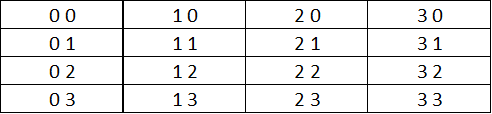

Recordemos que estas son las etiquetas de las coordenadas en un entorno 2x2.

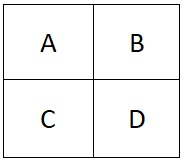

¿Cómo garantizo que un agente pueda mantener limpio un entorno `VacuumEnvironment` 2x2?

In [14]:
def program(percepts):
  #Si alguna de mis percepciones es un Dirt... debo limpiar
  #Puede que mi primera percepción no sea un Dirt!
  for pp in percepts:
    if isinstance(pp, Dirt):
      return 'Suck'


  #si no está sucio... Reflexivamente, le asigno una accion para cada posicion
  for pp in percepts:      
    if pp.location == loc_A:
      return 'Right'
    elif pp.location == loc_B:
      return 'Down'
    elif pp.location == loc_C:
      return 'Up'
    elif pp.location == loc_D:
      return 'Left'

In [15]:
class Dirt(Thing):
    pass

In [16]:
dirt = Dirt()
id(dirt)

140177338847808

In [17]:
dirt = Dirt()
id(dirt)

140177338847696

## Creamos y probamos el entorno

Solamente para la interfaz gráfica con [ipythonblocks](http://www.ipythonblocks.org/), la representación de coordenadas es: [`fila`, `columna`]. Para más información, consulte el [código fuente](https://github.com/jiffyclub/ipythonblocks/blob/master/ipythonblocks/ipythonblocks.py#L55).

In [18]:
room = VacuumEnvironment(3,2, color={'VacuumBot': (200,0,0), 'Dirt': (133, 122, 111)}, autoDirt=True, verbose=False) # room width is set to 2, and height to 2
vacuumBot = VacuumBot(program)
dirt = Dirt()
moredirt = Dirt()
room.add_thing(dirt, loc_A)
room.add_thing(moredirt, loc_C)

In [19]:
room.get_world()

[[[<__main__.Dirt at 0x7f7d947f3208>], [<__main__.Dirt at 0x7f7da167f320>]],
 [[], []],
 [[], []]]

In [20]:
room.add_thing(vacuumBot, location=loc_C)

In [21]:
room.get_world()

[[[<__main__.Dirt at 0x7f7d947f3208>],
  [<__main__.Dirt at 0x7f7da167f320>, <__main__.VacuumBot at 0x7f7d947f3c88>]],
 [[], []],
 [[], []]]

In [22]:
vacuumBot2 = VacuumBot(program)

In [23]:
room.add_thing(vacuumBot2, location=loc_A)

In [24]:
room.get_world()

[[[<__main__.Dirt at 0x7f7d947f3208>, <__main__.VacuumBot at 0x7f7d947f3e10>],
  [<__main__.Dirt at 0x7f7da167f320>, <__main__.VacuumBot at 0x7f7d947f3c88>]],
 [[], []],
 [[], []]]

In [25]:
room.verbose=True #cambio directo al atributo. existe otra manera de cambiar parámetros del entorno? 

In [26]:
room.get_world()

[[[<__main__.Dirt at 0x7f7d947f3208>, <__main__.VacuumBot at 0x7f7d947f3e10>],
  [<__main__.Dirt at 0x7f7da167f320>, <__main__.VacuumBot at 0x7f7d947f3c88>]],
 [[], []],
 [[], []]]

In [27]:
room.autoDirt=True

In [28]:
room.run(20)

,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7da167f320>] en [0, 1]
__main__.VacuumBot object at 0x7f7d947f3c88 limpió __main__.Dirt object at 0x7f7da167f320 en la ubicación: [0, 1]
------> Acabo de ensuciar la casilla: 2 0
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d947f3208>] en [0, 0]
__main__.VacuumBot object at 0x7f7d947f3e10 limpió __main__.Dirt object at 0x7f7d947f3208 en la ubicación: [0, 0]


,,
,,


********************************************************************
Agente se va a mover hacia arriba
------> Acabo de ensuciar la casilla: 1 1
********************************************************************
Agente se va a mover hacia la derecha


,,
,,


********************************************************************
Agente se va a mover hacia la derecha
********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 0 1
------> Acabo de ensuciar la casilla: 2 1


,,
,,


********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 1 0
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7daed4fef0>] en [1, 1]
__main__.VacuumBot object at 0x7f7d947f3e10 limpió __main__.Dirt object at 0x7f7daed4fef0 en la ubicación: [1, 1]


,,
,,


********************************************************************
Agente se va a mover hacia la izquierda
********************************************************************
Agente se va a mover hacia la izquierda


,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d947f3ef0>] en [0, 1]
__main__.VacuumBot object at 0x7f7d947f3c88 limpió __main__.Dirt object at 0x7f7d947f3ef0 en la ubicación: [0, 1]
********************************************************************


,,
,,


********************************************************************
Agente se va a mover hacia arriba
********************************************************************
Agente se va a mover hacia arriba
------> Acabo de ensuciar la casilla: 0 1


,,
,,


********************************************************************
Agente se va a mover hacia la derecha
------> Acabo de ensuciar la casilla: 1 1
********************************************************************
Agente se va a mover hacia la derecha


,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d947f3c50>] en [1, 0]
__main__.VacuumBot object at 0x7f7d947f3c88 limpió __main__.Dirt object at 0x7f7d947f3c50 en la ubicación: [1, 0]
------> Acabo de ensuciar la casilla: 0 0
********************************************************************


,,
,,


********************************************************************
Agente se va a mover hacia abajo
********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 1 0


,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7da9eb0828>] en [1, 1]
__main__.VacuumBot object at 0x7f7d947f3c88 limpió __main__.Dirt object at 0x7f7da9eb0828 en la ubicación: [1, 1]
********************************************************************


,,
,,


********************************************************************
Agente se va a mover hacia la izquierda
********************************************************************
Agente se va a mover hacia la izquierda


,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9dc43da0>] en [0, 1]
__main__.VacuumBot object at 0x7f7d947f3c88 limpió __main__.Dirt object at 0x7f7d9dc43da0 en la ubicación: [0, 1]
********************************************************************


,,
,,


********************************************************************
Agente se va a mover hacia arriba
********************************************************************
Agente se va a mover hacia arriba


,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d947f35f8>] en [0, 0]
__main__.VacuumBot object at 0x7f7d947f3c88 limpió __main__.Dirt object at 0x7f7d947f35f8 en la ubicación: [0, 0]
------> Acabo de ensuciar la casilla: 0 1
------> Acabo de ensuciar la casilla: 1 1
********************************************************************


,,
,,


********************************************************************
Agente se va a mover hacia la derecha
********************************************************************
Agente se va a mover hacia la derecha


,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d947f3668>] en [1, 0]
__main__.VacuumBot object at 0x7f7d947f3c88 limpió __main__.Dirt object at 0x7f7d947f3668 en la ubicación: [1, 0]
------> Acabo de ensuciar la casilla: 0 0
********************************************************************


,,
,,


********************************************************************
Agente se va a mover hacia abajo
********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 1 0


,,
,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d947f38d0>] en [1, 1]
__main__.VacuumBot object at 0x7f7d947f3c88 limpió __main__.Dirt object at 0x7f7d947f38d0 en la ubicación: [1, 1]
********************************************************************


,,
,,


********************************************************************
Agente se va a mover hacia la izquierda
********************************************************************
Agente se va a mover hacia la izquierda
------> Acabo de ensuciar la casilla: 1 1


,,
,,


In [29]:
vacuumBot.performance, vacuumBot2.performance

(68, 79)

## Para desarrollar

- Crear un entorno `room` de 4x4 de con dos agentes que se muevan de manera reflexiva. Se busca que puedan operar de forma autónoma. Las posiciones iniciales de los agentes deben ser diferentes entre sí.

- Para ello se deben generar dos secuencias de agentes que, en conjunto, garanticen que todas las casillas del entorno se lleguen a limpiar constantemente. Mostrar la secuencia de pasos de dichos agentes reflexivos en una imagen (0.25 puntos). Si están trabajando en Jupyter, y no se puede incrustar la imagen en el notebook ipynb, tiene que adjuntar su imagen en su archivo de entrega. Dicho fichero sería ahora un comprimido con extensión `.rar`.

- Implementar dos programas de agentes, de acuerdo a las secuencias (rutas) propuestas en su imagen (0.25 puntos por cada programa de agente).

- Activar la generación aleatoria de `Dirt` en el entorno creado, y modificarlo para que cada casilla tenga una probabilidad del `20%` de ensuciarse (0.25 puntos).

- **No** debe modificar la implementación del objeto `VacuumEnvironment`.

***

## Desarrollo del Desafío

Alumno: YGNACIO ROSAS, Frank Salvador.

### Secuencia 1:  **_Double-Clock_** 

Explicación

El presente programa muestra una secuencia única para ambos agentes que, **_en conjunto_**, garantice la limpieza de todas las casillas del entorno. La idea central está basada en tres condiciones: 1) mantener la unidireccionalidad del movimiento según posición; 2) poseer una misma lógica para los agentes que resulte útil en conjunto para la limpieza de los espacios; y 3) evitar la superposición de los mismos en una sola grilla. Este último requisito ayudará a que sus _performance_ no sean penalizados (-1) en caso este idéntico posicionamiento no derive en una acción de 'succión'. De ese modo, se optó por dividir imaginariamente el área 4x4 de la grilla en dos espacios 2x4. El objetivo de cada agente es volver al punto de origen pasando por todas las locaciones con base a esta espacialidad 2x4. La secuencia única está compuesta por una construcción de figurativa en sentido horario del reloj para cada una de las dos áreas (**_Double-Clock_**).


Gráfica | **Secuencia _Double-Clock_**:

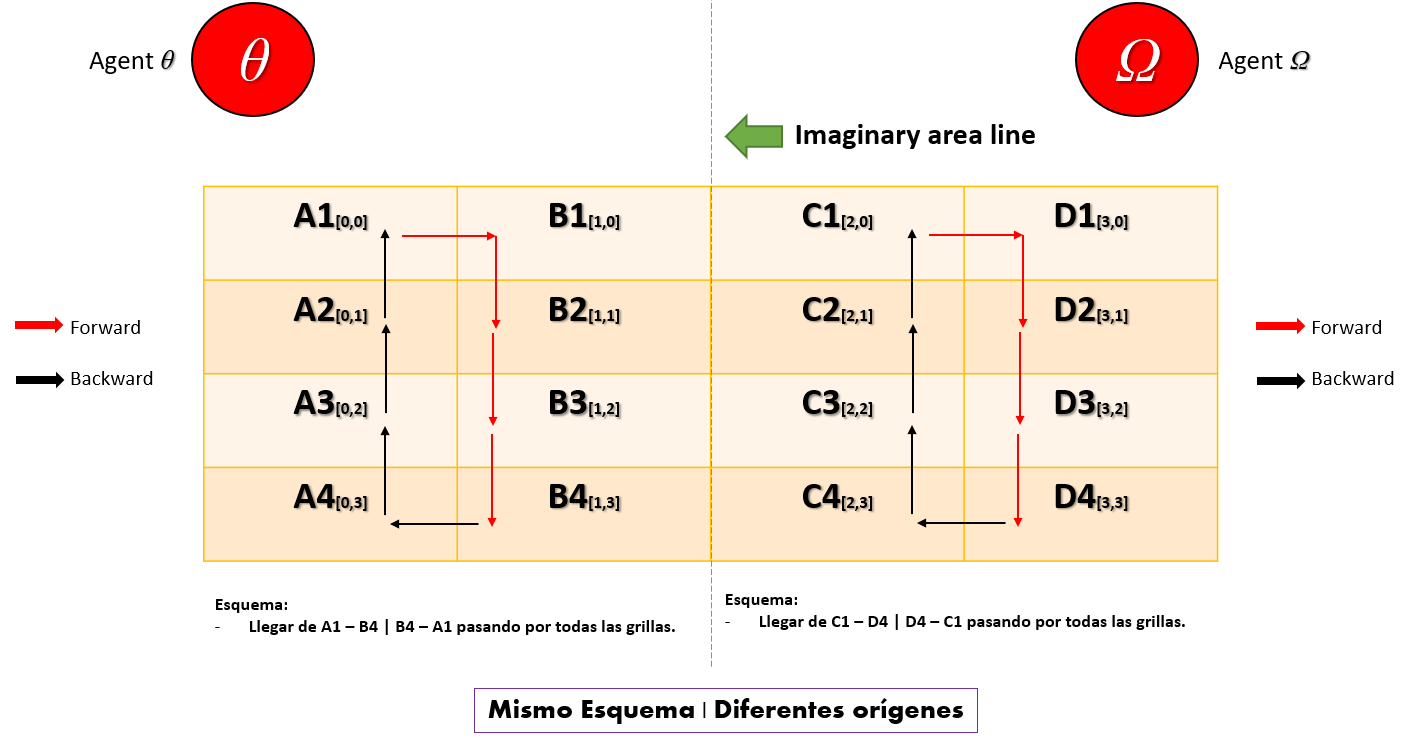

### Implementación de la **Secuencia _Double-Clock_** (programa)

##### Locations & Program

In [32]:
#1. Locaciones
loc_A1, loc_A2, loc_A3, loc_A4 = [0, 0], [0, 1], [0, 2], [0, 3]
loc_B1, loc_B2, loc_B3, loc_B4 = [1, 0], [1, 1], [1, 2], [1, 3]
loc_C1, loc_C2, loc_C3, loc_C4 = [2, 0], [2, 1], [2, 2], [2, 3] 
loc_D1, loc_D2, loc_D3, loc_D4 = [3, 0], [3, 1], [3, 2], [3, 3]

In [34]:
#2. Secuencia double-clock
def secuencia_doubleclock(percepts):

  #dirt perception
  for pp in percepts:
    if isinstance(pp, Dirt):
      return 'Suck'

  #cases based on location
  cases_right = [loc_A1, loc_C1]
  cases_down = [loc_B1, loc_B2, loc_B3, loc_D1, loc_D2, loc_D3]
  cases_left = [loc_B4, loc_D4]
  cases_up = [loc_A4, loc_A3, loc_A2, loc_C4, loc_C3, loc_C2]

  #movements
  for pp in percepts:      
    if pp.location in cases_right:
      return 'Right'
    elif pp.location in cases_down:
      return 'Down'
    elif pp.location in cases_left:
      return 'Left'
    elif pp.location in cases_up:
      return 'Up'

##### Initial Environment State Definition

In [35]:
#3. Definición de habitación
room_doubleclock = VacuumEnvironment(
    4, 4, color={
        'VacuumBot': (200,0,0), 
        'Dirt': (133, 122, 111)
        }, 
        autoDirt=True, 
        verbose=False
        )

In [36]:
#4. Posicionamiento de suciedad inicial
room_doubleclock.add_thing(Dirt(), loc_C4)
#room_doubleclock.add_thing(Dirt(), loc_C4)

In [37]:
#5. Estado del Entorno Inicial | sin agentes 
room_doubleclock.get_world()

[[[], [], [], []],
 [[], [], [], []],
 [[], [], [], [<__main__.Dirt at 0x7f7d947cd780>]],
 [[], [], [], []]]

#### Agents definition

In [38]:
#6. Creación de agentes 'theta' y 'omega'
vacuumBot_agent_theta = VacuumBot(secuencia_doubleclock)
vacuumBot_agent_omega = VacuumBot(secuencia_doubleclock)

In [39]:
#7. Posicionamiento de agentes 'theta' y 'omega'
room_doubleclock.add_thing(vacuumBot_agent_theta, location=loc_B1)
room_doubleclock.add_thing(vacuumBot_agent_omega, location=loc_C3)

In [40]:
#8. Estado del Entorno Inicial | con agentes
room_doubleclock.get_world()

[[[], [], [], []],
 [[<__main__.VacuumBot at 0x7f7d940ab470>], [], [], []],
 [[],
  [],
 [[], [], [], []]]

In [41]:
#9. Activación Verbose & AutoDirt 
room_doubleclock.verbose=True  
room_doubleclock.autoDirt=True

#### Double Clock in action

In [42]:
#10. Secuencia Double-Clock en ejecución
room_doubleclock.run(10) 

,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 2 0
------> Acabo de ensuciar la casilla: 3 1
------> Acabo de ensuciar la casilla: 3 3
********************************************************************
Agente se va a mover hacia arriba
------> Acabo de ensuciar la casilla: 1 0
------> Acabo de ensuciar la casilla: 1 2
------> Acabo de ensuciar la casilla: 3 2


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 0 1
------> Acabo de ensuciar la casilla: 0 3
------> Acabo de ensuciar la casilla: 1 1
------> Acabo de ensuciar la casilla: 1 3
********************************************************************
Agente se va a mover hacia arriba
------> Acabo de ensuciar la casilla: 0 0
------> Acabo de ensuciar la casilla: 3 0


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d940ab5f8>] en [1, 2]
__main__.VacuumBot object at 0x7f7d940ab470 limpió __main__.Dirt object at 0x7f7d940ab5f8 en la ubicación: [1, 2]
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d940ab5c0>] en [2, 0]
__main__.VacuumBot object at 0x7f7d947cdf60 limpió __main__.Dirt object at 0x7f7d940ab5c0 en la ubicación: [2, 0]


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia abajo
********************************************************************
Agente se va a mover hacia la derecha


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d940abf98>] en [1, 3]
__main__.VacuumBot object at 0x7f7d940ab470 limpió __main__.Dirt object at 0x7f7d940abf98 en la ubicación: [1, 3]
------> Acabo de ensuciar la casilla: 2 2
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d940ab4a8>] en [3, 0]
__main__.VacuumBot object at 0x7f7d947cdf60 limpió __main__.Dirt object at 0x7f7d940ab4a8 en la ubicación: [3, 0]
------> Acabo de ensuciar la casilla: 1 2
------> Acabo de ensuciar la casilla: 2 1


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia la izquierda
------> Acabo de ensuciar la casilla: 0 2
********************************************************************
Agente se va a mover hacia abajo


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d940abc88>] en [0, 3]
__main__.VacuumBot object at 0x7f7d940ab470 limpió __main__.Dirt object at 0x7f7d940abc88 en la ubicación: [0, 3]
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d940ab6d8>] en [3, 1]
__main__.VacuumBot object at 0x7f7d947cdf60 limpió __main__.Dirt object at 0x7f7d940ab6d8 en la ubicación: [3, 1]


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia arriba
********************************************************************
Agente se va a mover hacia abajo


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d940ab0b8>] en [0, 2]
__main__.VacuumBot object at 0x7f7d940ab470 limpió __main__.Dirt object at 0x7f7d940ab0b8 en la ubicación: [0, 2]
------> Acabo de ensuciar la casilla: 1 3
------> Acabo de ensuciar la casilla: 3 0
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d940ab518>] en [3, 2]
__main__.VacuumBot object at 0x7f7d947cdf60 limpió __main__.Dirt object at 0x7f7d940ab518 en la ubicación: [3, 2]


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia arriba
------> Acabo de ensuciar la casilla: 2 0
********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 0 3


,,,
,,,
,,,
,,,


In [43]:
vacuumBot_agent_theta.performance, vacuumBot_agent_omega.performance

(34, 34)

### Implementación de la **Secuencia _Double-Clock_** (programa) - Versión Refactored

##### Locations & Refactored Program

In [56]:
def secuencia_doubleclock_refactored(percepts):
    #dirt perception
  for pp in percepts:
    if isinstance(pp, Dirt):
      return 'Suck'

  #movements
  for pp in percepts:
    col = pp.location[0]
    row = pp.location[1]

    if (col%2 ==0):#si es la columna 0 o 2...
      if (row==0):#si es la fila superior...
        return 'Right'
      else:
        return 'Up'
    else:
      if (row==3):#si es la fila inferior...
        return 'Left'
      else:
        return 'Down'

##### Initial Environment State Definition

In [57]:
#3. Definición de habitación
room_doubleclock = VacuumEnvironment(
    4, 4, color={
        'VacuumBot': (200,0,0), 
        'Dirt': (133, 122, 111)
        }, 
        autoDirt=True, 
        verbose=False
        )

In [58]:
#4. Posicionamiento de suciedad inicial
room_doubleclock.add_thing(Dirt(), loc_C4)
#room_doubleclock.add_thing(Dirt(), loc_C4)

In [59]:
#5. Estado del Entorno Inicial | sin agentes 
room_doubleclock.get_world()

[[[], [], [], []],
 [[], [], [], []],
 [[], [], [], [<__main__.Dirt at 0x7f7d950234e0>]],
 [[], [], [], []]]

#### Agents definition

In [60]:
#6. Creación de agentes 'theta' y 'omega'
vacuumBot_agent_theta = VacuumBot(secuencia_doubleclock)
vacuumBot_agent_omega = VacuumBot(secuencia_doubleclock)

In [61]:
#7. Posicionamiento de agentes 'theta' y 'omega'
room_doubleclock.add_thing(vacuumBot_agent_theta, location=loc_B1)
room_doubleclock.add_thing(vacuumBot_agent_omega, location=loc_C3)

In [62]:
#8. Estado del Entorno Inicial | con agentes
room_doubleclock.get_world()

[[[], [], [], []],
 [[<__main__.VacuumBot at 0x7f7d95023898>], [], [], []],
 [[],
  [],
 [[], [], [], []]]

In [66]:
#9. Activación Verbose & AutoDirt 
room_doubleclock.verbose=False  
room_doubleclock.autoDirt=False

#### Double Clock in action

In [67]:
#10. Secuencia Double-Clock en ejecución
room_doubleclock.run(10) 

,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


__main__.VacuumBot object at 0x7f7d95023898 limpió __main__.Dirt object at 0x7f7d940abba8 en la ubicación: [0, 0]
__main__.VacuumBot object at 0x7f7d95023c18 limpió __main__.Dirt object at 0x7f7d950234e0 en la ubicación: [2, 3]


,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


__main__.VacuumBot object at 0x7f7d95023898 limpió __main__.Dirt object at 0x7f7d947cd5c0 en la ubicación: [1, 0]
__main__.VacuumBot object at 0x7f7d95023c18 limpió __main__.Dirt object at 0x7f7d940ab780 en la ubicación: [2, 2]


,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


__main__.VacuumBot object at 0x7f7d95023898 limpió __main__.Dirt object at 0x7f7d940abda0 en la ubicación: [1, 1]
__main__.VacuumBot object at 0x7f7d95023c18 limpió __main__.Dirt object at 0x7f7d940ab668 en la ubicación: [2, 1]


,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


__main__.VacuumBot object at 0x7f7d95023898 limpió __main__.Dirt object at 0x7f7d940ab080 en la ubicación: [1, 2]
__main__.VacuumBot object at 0x7f7d95023c18 limpió __main__.Dirt object at 0x7f7d947cd198 en la ubicación: [2, 0]


,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


__main__.VacuumBot object at 0x7f7d95023898 limpió __main__.Dirt object at 0x7f7d940ab0f0 en la ubicación: [1, 3]
__main__.VacuumBot object at 0x7f7d95023c18 limpió __main__.Dirt object at 0x7f7d940abb70 en la ubicación: [3, 0]


,,,
,,,
,,,
,,,


In [68]:
vacuumBot_agent_theta.performance, vacuumBot_agent_omega.performance

(79, 79)

### Secuencia 2: **_L-Block_** + **_Clock Sequence_**

Explicación

El presente programa muestra una secuencia distinta para ambos agentes que, en conjunto, garantice la limpieza de todas las casillas del entorno. La idea central está basada en tres condiciones: 1) mantener la unidireccionalidad del movimiento según posición; 2) poseer una lógica distinta y complementaria para los agentes que resulte útil para la limpieza de los espacios; y 3) evitar la superposición de los mismos en una sola grilla. Este último requisito ayudará a que sus performance no sean penalizados (-1) en caso este idéntico posicionamiento no derive en una acción de 'succión'. De ese modo, se optó por desarrollar dos secuencias: una en forma de **L**, y otra en forma circular en secuencia horaria. El objetivo de cada agente es volver al punto de origen pasando por todas las locaciones. 


Gráfica | **Secuencia _'L - Block'_ + _Clock Sequence_**:

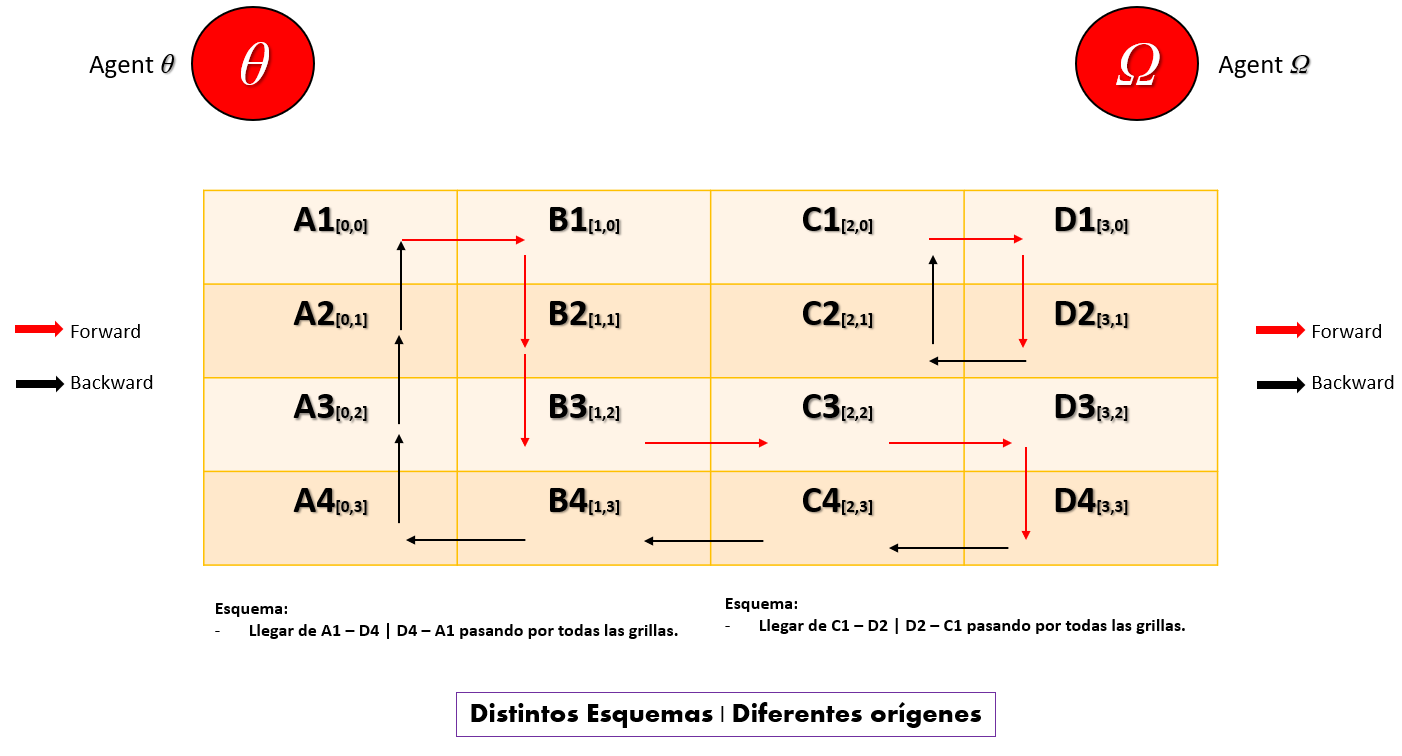

### Implementación de la **Secuencia 'L - Block' + Clock Sequence** (programa)

#### Locations & Program

In [44]:
#1. Locaciones
loc_A1, loc_A2, loc_A3, loc_A4 = [0, 0], [0, 1], [0, 2], [0, 3]
loc_B1, loc_B2, loc_B3, loc_B4 = [1, 0], [1, 1], [1, 2], [1, 3]
loc_C1, loc_C2, loc_C3, loc_C4 = [2, 0], [2, 1], [2, 2], [2, 3] 
loc_D1, loc_D2, loc_D3, loc_D4 = [3, 0], [3, 1], [3, 2], [3, 3]

In [45]:
#2. Secuencia double-clock
def secuencia_L_block(percepts):

  #dirt perception
  for pp in percepts:
    if isinstance(pp, Dirt):
      return 'Suck'

  #cases based on location
  cases_right = [loc_A1, loc_B3, loc_C3]
  cases_down = [loc_B1, loc_B2, loc_D3]
  cases_left = [loc_D4, loc_C4, loc_B4]
  cases_up = [loc_A4, loc_A3, loc_A2]

  #movements
  for pp in percepts:      
    if pp.location in cases_right:
      return 'Right'
    elif pp.location in cases_down:
      return 'Down'
    elif pp.location in cases_left:
      return 'Left'
    elif pp.location in cases_up:
      return 'Up'

In [46]:
#3. Secuencia clock
def secuencia_simple_clock(percepts):
  #Si alguna de mis percepciones es un Dirt... debo limpiar
  #Puede que mi primera percepción no sea un Dirt!
  for pp in percepts:
    if isinstance(pp, Dirt):
      return 'Suck'


  #si no está sucio... Reflexivamente, le asigno una accion para cada posicion
  for pp in percepts:      
    if pp.location == loc_C1:
      return 'Right'
    elif pp.location == loc_D1:
      return 'Down'
    elif pp.location == loc_D2:
      return 'Left'    
    elif pp.location == loc_C2:
      return 'Up'

#### Initial Environment State Definition

In [47]:
#4. Definición de habitación
room_L_clock = VacuumEnvironment(
    4, 4, color={
        'VacuumBot': (200,0,0), 
        'Dirt': (133, 122, 111)
        }, 
        autoDirt=True, 
        verbose=False
        )

In [48]:
#5. Posicionamiento de suciedad inicial
room_L_clock.add_thing(Dirt(), loc_C4)
#room_doubleclock.add_thing(Dirt(), loc_C4)

In [49]:
#6. Estado del Entorno Inicial | sin agentes 
room_L_clock.get_world()

[[[], [], [], []],
 [[], [], [], []],
 [[], [], [], [<__main__.Dirt at 0x7f7d9409b7f0>]],
 [[], [], [], []]]

#### Agents definition

In [50]:
#7. Creación de agentes 'theta' y 'omega'
vacuumBot_agent_theta_ = VacuumBot(secuencia_L_block)
vacuumBot_agent_omega_ = VacuumBot(secuencia_simple_clock)

In [51]:
#8. Posicionamiento de agentes 'theta' y 'omega'
room_L_clock.add_thing(vacuumBot_agent_theta_, location=loc_A1)
room_L_clock.add_thing(vacuumBot_agent_omega_, location=loc_C1)

In [52]:
#9. Estado del Entorno Inicial | con agentes
room_L_clock.get_world()

[[[<__main__.VacuumBot at 0x7f7d9409bef0>], [], [], []],
 [[], [], [], []],
 [[<__main__.VacuumBot at 0x7f7d9409be10>],
  [],
  [],
 [[], [], [], []]]

In [53]:
#10. Activación Verbose & AutoDirt 
room_L_clock.verbose=True  
room_L_clock.autoDirt=True

#### L - Block + Clock Sequence in action

In [54]:
#10. Secuencia Double-Clock en ejecución
room_L_clock.run(20) 

,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia la derecha
------> Acabo de ensuciar la casilla: 0 0
------> Acabo de ensuciar la casilla: 2 2
------> Acabo de ensuciar la casilla: 3 2
********************************************************************
Agente se va a mover hacia la derecha
------> Acabo de ensuciar la casilla: 2 0


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 1 0
------> Acabo de ensuciar la casilla: 3 3
********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 0 1


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 1 1
********************************************************************
Agente se va a mover hacia la izquierda
------> Acabo de ensuciar la casilla: 3 1


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia la derecha
********************************************************************
Agente se va a mover hacia arriba
------> Acabo de ensuciar la casilla: 1 2


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409b278>] en [2, 2]
__main__.VacuumBot object at 0x7f7d9409bef0 limpió __main__.Dirt object at 0x7f7d9409b278 en la ubicación: [2, 2]
------> Acabo de ensuciar la casilla: 0 2
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409b940>] en [2, 0]
__main__.VacuumBot object at 0x7f7d9409be10 limpió __main__.Dirt object at 0x7f7d9409b940 en la ubicación: [2, 0]


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia la derecha
------> Acabo de ensuciar la casilla: 1 3
********************************************************************
Agente se va a mover hacia la derecha


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409b860>] en [3, 2]
__main__.VacuumBot object at 0x7f7d9409bef0 limpió __main__.Dirt object at 0x7f7d9409b860 en la ubicación: [3, 2]
------> Acabo de ensuciar la casilla: 2 0
********************************************************************
Agente se va a mover hacia abajo


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 0 3
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409bf98>] en [3, 1]
__main__.VacuumBot object at 0x7f7d9409be10 limpió __main__.Dirt object at 0x7f7d9409bf98 en la ubicación: [3, 1]
------> Acabo de ensuciar la casilla: 3 2


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409b6a0>] en [3, 3]
__main__.VacuumBot object at 0x7f7d9409bef0 limpió __main__.Dirt object at 0x7f7d9409b6a0 en la ubicación: [3, 3]
********************************************************************
Agente se va a mover hacia la izquierda
------> Acabo de ensuciar la casilla: 3 0


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia la izquierda
------> Acabo de ensuciar la casilla: 2 2
------> Acabo de ensuciar la casilla: 3 3
********************************************************************
Agente se va a mover hacia arriba


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409b7f0>] en [2, 3]
__main__.VacuumBot object at 0x7f7d9409bef0 limpió __main__.Dirt object at 0x7f7d9409b7f0 en la ubicación: [2, 3]
------> Acabo de ensuciar la casilla: 3 1
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409b278>] en [2, 0]
__main__.VacuumBot object at 0x7f7d9409be10 limpió __main__.Dirt object at 0x7f7d9409b278 en la ubicación: [2, 0]


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia la izquierda
********************************************************************
Agente se va a mover hacia la derecha


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409b940>] en [1, 3]
__main__.VacuumBot object at 0x7f7d9409bef0 limpió __main__.Dirt object at 0x7f7d9409b940 en la ubicación: [1, 3]
------> Acabo de ensuciar la casilla: 2 3
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409b6a0>] en [3, 0]
__main__.VacuumBot object at 0x7f7d9409be10 limpió __main__.Dirt object at 0x7f7d9409b6a0 en la ubicación: [3, 0]


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia la izquierda
********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 2 0


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409b898>] en [0, 3]
__main__.VacuumBot object at 0x7f7d9409bef0 limpió __main__.Dirt object at 0x7f7d9409b898 en la ubicación: [0, 3]
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409b780>] en [3, 1]
__main__.VacuumBot object at 0x7f7d9409be10 limpió __main__.Dirt object at 0x7f7d9409b780 en la ubicación: [3, 1]
------> Acabo de ensuciar la casilla: 1 3


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia arriba
********************************************************************
Agente se va a mover hacia la izquierda


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409bf60>] en [0, 2]
__main__.VacuumBot object at 0x7f7d9409bef0 limpió __main__.Dirt object at 0x7f7d9409bf60 en la ubicación: [0, 2]
********************************************************************
Agente se va a mover hacia arriba


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia arriba
------> Acabo de ensuciar la casilla: 0 3
------> Acabo de ensuciar la casilla: 3 1
********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409b6a0>] en [2, 0]
__main__.VacuumBot object at 0x7f7d9409be10 limpió __main__.Dirt object at 0x7f7d9409b6a0 en la ubicación: [2, 0]


,,,
,,,
,,,
,,,


********************************************************************
Quiero limpiar las dirts [<__main__.Dirt object at 0x7f7d9409beb8>] en [0, 1]
__main__.VacuumBot object at 0x7f7d9409bef0 limpió __main__.Dirt object at 0x7f7d9409beb8 en la ubicación: [0, 1]
********************************************************************
Agente se va a mover hacia la derecha


,,,
,,,
,,,
,,,


********************************************************************
Agente se va a mover hacia arriba
------> Acabo de ensuciar la casilla: 2 1
********************************************************************
Agente se va a mover hacia abajo
------> Acabo de ensuciar la casilla: 0 2


,,,
,,,
,,,
,,,


In [55]:
vacuumBot_agent_theta_.performance, vacuumBot_agent_omega_.performance

(68, 46)